# Exercises for the *Weather and Uncertainty* workshop

<ul>
<li> author: Parag Rastogi
<li> venue: CEPT University, Ahmedabad, India.
<li> date: 06 January, 2018.
</ul>

Run each module one-by-one by either using the <kbd>run cell</kbd> button above or pressing <kbd>Ctrl + Enter</kbd> when a cell is selected.

In [1]:
# Import various standard modules.
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Get inline graphs .
%matplotlib inline

# Only useful for debugging, when you 
# need to reload external modules.
from importlib import reload

# Enable xkcd mode - if you're a nerd.
# plt.xkcd()

# Import a custom read-write function for
# reading and writing in EPW files.
import wfileio as wf

# import small helpers I've written.
from petites import *

# Import an awesome colour palette. Call it colours.
import default_colours as colours

# Set the random seed to a specific value so
# the experiment is repeatable.
# See https://en.wikipedia.org/wiki/Random_seed
# for more information on what this means.
np.random.seed(42)

In [2]:
# Read Dehradun location data.
path_epw_ddn = os.path.join('..', 'ddn', 'IND_UT_Dehradun.421110_ISHRAE2014.epw')
ddn, locdata, header, _ = wf.get_weather('ddn', path_epw_ddn, ftype='epw')

# Save some metadata about the location.
metadata_ddn = dict(locdata=locdata, header=header)

# # Do the same with Ahmedabad data.
# path_epw_amd = os.path.join('..', 'amd', 'IND_GJ_Ahmedabad-Patel.Intl.AP.426470_ISHRAE2014.epw')
# amd, locdata, header, _ = wf.get_weather('amd', path_epw_amd, ftype='epw')

# metadata_amd = dict(locdata=locdata, header=header)

# Set the variable 'tmy' to the incoming data from Dehradun - so changing 
# this statement will allow you to run the worksheet with any location.
tmy = ddn

print('======')

Running weather file reader for station ddn. Expecting format epw.



In [3]:
tmy.head()

,year,month,day,hour,minute,qualflags,tdb,tdp,rh,atmpr,...,tsky,osky,vis,chgt,pwo,pwc,pwt,aopt,sdpt,slast
2017-01-01 00:00:00,2017,1,1,1,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,6.7,4.7,87,94000,...,0,0,2.0,77777,9,999999999,129,0.0,0,88
2017-01-01 01:00:00,2017,1,1,2,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,6.7,4.2,84,94000,...,0,0,2.0,77777,9,999999999,120,0.0,0,88
2017-01-01 02:00:00,2017,1,1,3,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,6.1,3.7,85,94000,...,0,0,2.0,77777,9,999999999,120,0.0,0,88
2017-01-01 03:00:00,2017,1,1,4,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,6.1,3.8,85,94000,...,0,0,2.0,77777,9,999999999,120,0.0,0,88
2017-01-01 04:00:00,2017,1,1,5,0,?9?9?9?9E0?9?9?9?9*9?9?9?9?9*9?9?9?9?9*_*9*9,5.6,3.3,85,94000,...,0,0,2.0,77777,9,999999999,120,0.0,0,88


For this exercise we will use the equation presented in Clarke (2001, Chpt. 7, sec. 7.1, pg. 206):

$ E = a \theta^2 + b R_d^2 + c R_f^2 + d V^2 + e \theta + f R_d + g R_f + h V + i \theta R_d + j \theta R_f + k \theta V + l R_d R_f + m R_d V + n R_f V + o, \quad$  (1)

where "$E$ is the monthly energy requirement \[kWh\], $\theta$ the monthly mean temperature \[$^o$C\], $R_d$ the monthly mean direct normal solar radiation \[W/$m^2$\], $R_f$ the monthly mean diffuse horizontal solar radiation \[W/$m^2$\], $V$ the montly mean wind speed [m/s], and 'a' through 'o' are the least squares coefficients" (ibid).

**NB**: The equation in the code is the same as this one, I've just rearranged the parameters and stated the constants as elements of an array rather than as separate variables. Also, I have omitted the bars over the variable names since the markdown rendering of bars and powers is awkward.

In [4]:
# Define a function to calculate monthly energy use using the equation given in Clarke (2001).

def E_month(theta, R_d, R_f, V, beta=np.random.rand(15,1)):

    # Use random coefficients to calculate the energy use for the first exercise. 
    # This is just for a demo since the coefficients are never 
    # going to be 'random', unless you have no idea what you are doing.
    
    # For the second exercise, fix the coefficients to some value and use
    # randomly sampled inputs.
        
    e = beta[0] + beta[1]*theta + beta[2]*R_d + beta[3]*R_f + beta[4]*V + \
            beta[5]*theta**2 + beta[6]*R_d**2 + beta[7]*R_f**2 + beta[8]*V**2 + \
            beta[9]*theta*R_d + beta[10]*theta*R_f + beta[11]*theta*V + \
            beta[12]*R_d*R_f + beta[13]*R_d*V + beta[14]*R_f*V
    
    return e


## Random coefficients, fixed inputs

For the first exercise, let's fix the inputs to typical values and use random coefficients to specify the relationship between inputs and output. 

The simulators you use will almost never be random - for buildings at least - so just treat this as an exercise. Imagine the building is changing, so its response to the weather inputs is changing.

In [5]:
# Calculate the monthly mean values of weather parameters for Dehradun.

relevant_keys = ['tdb', 'dni', 'ghi', 'wspd']

# Declare an empty dataframe.
tmy_summary = pd.DataFrame()

# Assign individual columns.
# Each weather parameter is grouped by month, and the monthly mean calculated.
tmy_summary['month'] = pd.unique(ddn['month'])
tmy_summary.index = tmy_summary['month']

for key in tmy.columns:
    if key not in relevant_keys:
        continue
    tmy_summary[key] = tmy.groupby(by=['month'])[key].mean()

# Calculate the monthly energy consumption with random coefficients.
tmy_summary['energy'] = E_month(tmy_summary['tdb'], tmy_summary['dni'],
                                       tmy_summary['ghi'], tmy_summary['wspd'])

tmy_summary.head()

,month,tdb,ghi,dni,wspd,energy
month,,,,,,
1,1,12.034409,149.819892,241.672043,0.507392,55418.543694
2,2,14.740625,183.520833,238.776786,0.634077,71905.935973
3,3,19.059409,231.887097,258.701613,0.861962,104486.733894
4,4,24.786389,281.461111,282.808333,0.768750,145233.204547
5,5,27.858468,317.811828,320.717742,0.934005,185536.268159


In [6]:
# Do groupby manually using a for loop.

# You don't need this - this is just a demo to show you how much easier your life is with pandas!

tmy_summary2 = np.zeros_like(tmy_summary)

for month in tmy_summary.index:
    mask = ddn['month'] == month
    tmy_summary2[month-1, tmy_summary.columns=='month'] = month
    for key in tmy.columns:
        if key not in relevant_keys:
            continue
        tmy_summary2[month-1, tmy_summary.columns==key] = np.mean(tmy.loc[mask, key])

        # End inner for loop.
# End outer for loop.    

tmy_summary2 = pd.DataFrame(data=tmy_summary2,
                            index=pd.unique(ddn['month']),
                            columns=tmy_summary.columns)

tmy_summary2['energy'] = E_month(tmy_summary2['tdb'], tmy_summary2['dni'],
                                        tmy_summary2['ghi'], tmy_summary2['wspd'])

print('The two dataframes should match, so most of the differences should be close to zero.')

The two dataframes should match, so most of the differences should be close to zero.


In [7]:
diffs = tmy_summary2.values-tmy_summary.values
print('Median = {0:4.3e}; Max. = {1:4.3e}; Min = {2:4.3e}.'.format(np.median(diffs), np.max(diffs), np.min(diffs)))

Median = 0.000e+00; Max. = 2.487e-14; Min = -2.910e-11.


In [8]:
# Try smoothing instead of using a monthly average.

def smoother(xin, lags):
    
    xout = np.zeros_like(xin)
    
    # Convert even numbers to odd.
    if np.mod(lags, 2) == 0:
        lags = lags + 1
        
    halfspan = int(np.floor(lags/2))
        
    for n, x in enumerate(xin):
        
        if (n < halfspan):
            xout[n] = np.nanmean(xin[0:halfspan])
        
        elif (n > (xin.shape[0] - halfspan)):
            xout[n] = np.nanmean(xin[-halfspan:-1])
        
        else:
            lb = int(n - halfspan)
            ub = int(n + halfspan)
            xout[n] = np.nanmean(xin[lb:ub])
        
        # End IF statement.
        
    # End FOR loop.
    
    return xout

We're going to use the smoothed data to calculate energy use but be aware that the original regression relationship was created with *monthly values*.

In [9]:
span = 720

ddn_smooth = pd.DataFrame(data = np.zeros(tmy.shape), columns=tmy.columns, index=tmy.index)

for key in tmy.columns:
    if key not in relevant_keys:
        continue
    ddn_smooth[key] = smoother(ddn[key].values, span)
    
ddn_smooth['energy'] = E_month(ddn_smooth['tdb'], ddn_smooth['dni'],
                                       ddn_smooth['ghi'], ddn_smooth['wspd'])

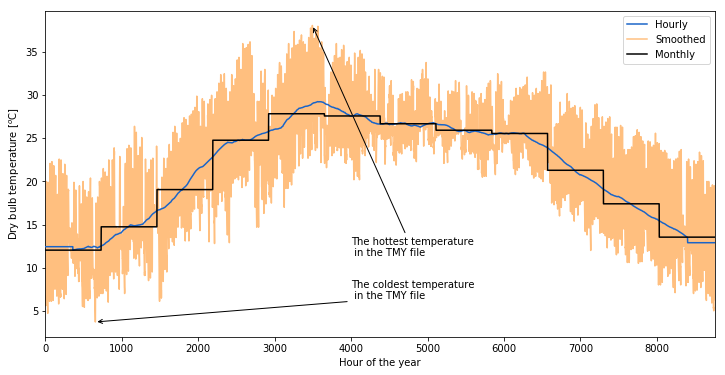

In [10]:
plot_x = np.arange(0, tmy.shape[0])
# Find the index and value of the max temperature.
ymax = np.max(ddn['tdb'].values)
xmax = plot_x[ddn['tdb'].values==ymax]
ymin = np.min(ddn['tdb'].values)
xmin = plot_x[ddn['tdb'].values==ymin]

fig, ax = plt.subplots(figsize=[12,6])
ax.plot(plot_x, ddn_smooth['tdb'].values, zorder=10, color=colours.blue)
ax.plot(plot_x, ddn['tdb'].values, zorder = 1, color=colours.orange, alpha=0.5)
ax.plot(plot_x, np.repeat(tmy_summary['tdb'], 8760/12), color=colours.blackest, zorder=11)
plt.legend(['Hourly', 'Smoothed', 'Monthly'])
plt.ylabel('Dry bulb temperature [$^o$C]')
plt.xlabel('Hour of the year')
plt.xlim(plot_x[0], plot_x[-1])
plt.annotate('The hottest temperature \n in the TMY file\n',
    xy=(xmax, ymax), arrowprops=dict(arrowstyle='->'), xytext=(4000, 10))
plt.annotate('The coldest temperature \n in the TMY file\n',
    xy=(xmin, ymin), arrowprops=dict(arrowstyle='->'), xytext=(4000, 5))
plt.show()


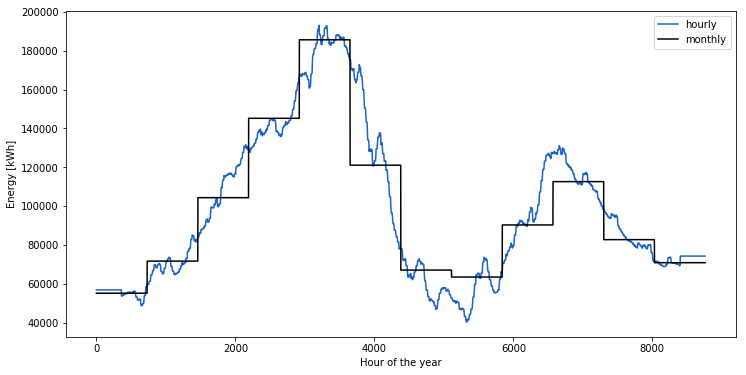

In [11]:
plot_x = range(0, tmy.shape[0])
fig, ax = plt.subplots(figsize=[12,6])
ax.plot(plot_x, ddn_smooth['energy'], alpha=1, zorder=3, color=colours.blue)
ax.plot(plot_x, np.repeat(tmy_summary['energy'], 8760/12), color=colours.blackest, zorder=10)
plt.legend(['hourly', 'monthly'])
plt.ylabel('Energy [kWh]')
plt.xlabel('Hour of the year')
plt.show()

In [12]:
# Repeat the above exercise with data from Ahmedabad.


In [13]:
# Plot comparisons of weather from Dehradun and Ahmedabad.
# Realise Dehradun is a far superior place to live than Ahmedabad. 


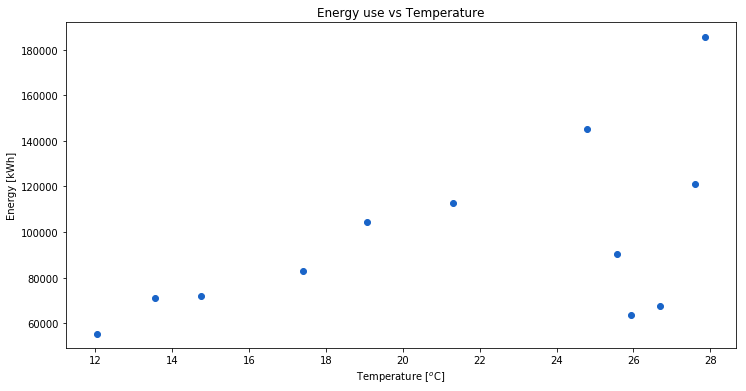

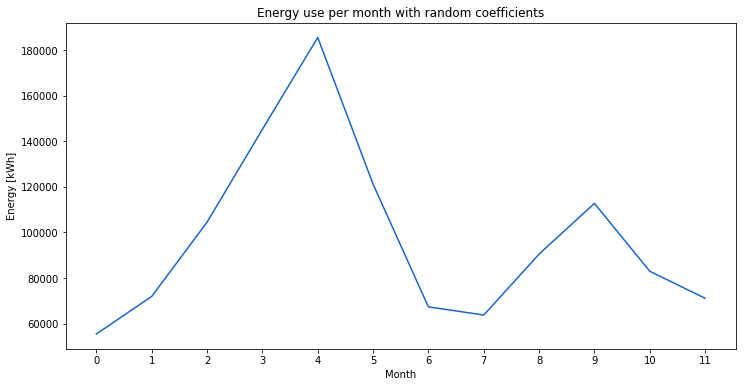

In [14]:
fig, ax = plt.subplots(figsize=[12,6])
ax.scatter(tmy_summary['tdb'], tmy_summary['energy'], color=colours.blue)
plt.ylabel('Energy [kWh]')
plt.xlabel('Temperature [$^o$C]')
plt.title('Energy use vs Temperature')
plt.show()

fig, ax = plt.subplots(figsize=[12,6])
ax.plot(range(0, tmy_summary.shape[0]), tmy_summary['energy'], color=colours.blue)
plt.ylabel('Energy [kWh]')
plt.xlabel('Month')
plt.title('Energy use per month with random coefficients')
plt.xticks(range(0, 12))
plt.show()

## Fixed coefficients, random inputs

Now let's try the same exercise with fixed coefficients and random inputs.


In [15]:
# import the Python module that can read these kinds of files.
import h5py

path_to_synw = os.path.join('..', 'ddn', 'IND_UT_Dehradun.421110_ISHRAE2014_Syn.mat')

# The column names we expect to see in the synthetic files.
column_names = ('year', 'month', 'day', 'hour', 'tdb', 'tdp', 'rh',
                'ghi', 'dni', 'dhi', 'wspd', 'wdr')
dc = 4  # No. of date columns.

In [16]:
# Make a variable to point to the file.
f = h5py.File(path_to_synw)
# Specify an empty dataframe.
syndata = pd.DataFrame()

# Take each 'key' (variable) from the file and assign it to syndata.
for key in f['syndata']:
    syndata[key.lower()] = pd.Series(np.squeeze(np.array(f['syndata'][key])))

f.close()

# Number of years in dataset.
n_years = np.unique(syndata['year']).size
n_hours = 8760  # Fixed for this dataset.

In [17]:
# Add wspd key.
syndata['wspd'] = pd.Series(data=np.repeat(ddn['wspd'].values, n_years), index=syndata.index)
syndata['wdr'] = pd.Series(data=np.repeat(ddn['wdr'].values, n_years), index=syndata.index)
syndata['tdp'] = pd.Series(data=calc_tdp(syndata['tdb'].values, syndata['rh'].values), index=syndata.index)

In [18]:
# Rearrange the date columns of this dataframe.
# The columns should have been in this order already
# but something was probably wrong in the reading/writing
# or generation of the synthetic file.

cols = syndata.columns.tolist()
# print(ddn.columns)
myorder = [3, 2, 0, 1, 8, 11, 7, 6, 5, 4, 9, 10]
cols = [cols[i] for i in myorder]
syndata = syndata[cols]
print(syndata.columns)

Index(['year', 'month', 'day', 'hour', 'tdb', 'tdp', 'rh', 'ghi', 'dni', 'dhi',
       'wspd', 'wdr'],
      dtype='object')


In [19]:
# Now let's fix the coefficients to some arbitrary values and plot inputs from  

span = 720

syn_smooth = pd.DataFrame(data = np.zeros(syndata.shape), columns=syndata.columns, index=syndata.index)

for key in syndata.columns:
    if key not in relevant_keys:
        syn_smooth[key] = syndata[key].values
    else:
        syn_smooth[key] = smoother(syndata[key].values, span)
    
syn_smooth['energy'] = E_month(syn_smooth['tdb'], syn_smooth['dni'],
                               syn_smooth['ghi'], syn_smooth['wspd'],
                               beta=np.ones([15, 1]))

In [20]:
# It is generally not good practice to load modules after some code has been written.
# If I were to write this as a program, I would shift these calls to the top.
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

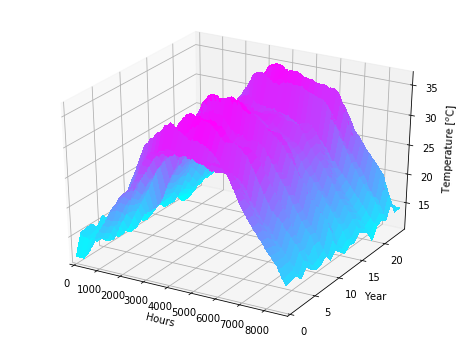

In [21]:
x = range(0, n_hours)
y = range(0, n_years)

# Line plot.
fig = plt.figure(figsize=(8, 6), facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')

X, Y = np.meshgrid(x,y)
Z = syn_smooth['tdb'].values.reshape(-1, n_hours)

surf = ax.plot_surface(X, Y, Z, cmap=cm.cool,
                       linewidth=0, antialiased=False)

ax.set_xlim(0, n_hours)
ax.set_ylim(y[0], y[-1])
ax.set_zlim(np.min(Z), np.max(Z))

ax.set_ylabel('Year')
ax.set_xlabel('Hours')
ax.set_zlabel('Temperature [$^o$C]')

plt.show()

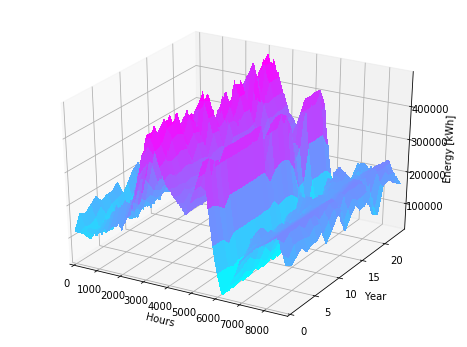

In [22]:
x = range(0, n_hours)
y = range(0, n_years)

# Line plot.
fig = plt.figure(figsize=(8, 6), facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')

X, Y = np.meshgrid(x,y)
Z = syn_smooth['energy'].values.reshape(-1, n_hours)

surf = ax.plot_surface(X, Y, Z, cmap=cm.cool,
                       linewidth=0, antialiased=False)

ax.set_xlim(0, n_hours)
ax.set_ylim(y[0], y[-1])
ax.set_zlim(np.min(Z), np.max(Z))

ax.set_ylabel('Year')
ax.set_xlabel('Hours')
ax.set_zlabel('Energy [kWh]')

ax.set_zticks(np.arange(100000, 500000, 100000), )

plt.show()

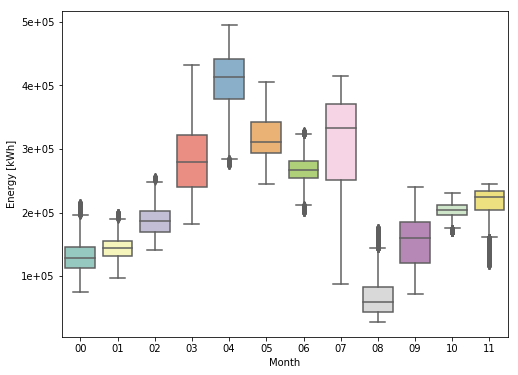

In [23]:
x = range(0, n_hours)
y = range(0, n_years)

# Line plot.
fig = plt.figure(figsize=(8, 6), facecolor='w', edgecolor='k')
ax = fig.gca()

# X, Y = np.meshgrid(x,y)
# z = syn_smooth['energy'].values.reshape(-1, n_hours)

bp = sns.boxplot(x='month', y='energy', data=syn_smooth, palette='Set3')

# ax.set_xlim(0, n_hours)
# ax.set_ylim(y[0], y[-1])
# ax.set_zlim(np.min(Z), np.max(Z))

ax.yaxis.set_major_formatter(FormatStrFormatter('%4.0e'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%02d'))

# ax.set_ylabel('Year')
ax.set_xlabel('Month')
ax.set_ylabel('Energy [kWh]')

plt.show()

# Solar power with random weather inputs

## Optional

Use the `solar_power_func` to plot solar power production with random inputs. This function uses the procedure laid out in the iPython notebook: `solar_power`. 

I'm having trouble writing out the synthetic data to an EPW file for the `solar_power` function to read, but if you're interested we can talk about this.

Bonus exercise: optimise tilt and/or orientation angle.

In [24]:
import solar_power_func as solar

In [25]:
power = solar.tmy_to_power(path_tmy_data=path_epw_ddn,
                           surface_tilt=30, surface_azimuth=180,
                           albedo=0.2, silent=True)

Running weather file reader for station tmy_data. Expecting format epw.



C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1463: RuntimeWarning: invalid value encountered in maximum
  spectral_loss = np.maximum(0, np.polyval(am_coeff, airmass_absolute))
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1317: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1323: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1919: RuntimeWarning: overflow encountered in exp
  (Gsh[idx_p]*a[idx_p]))


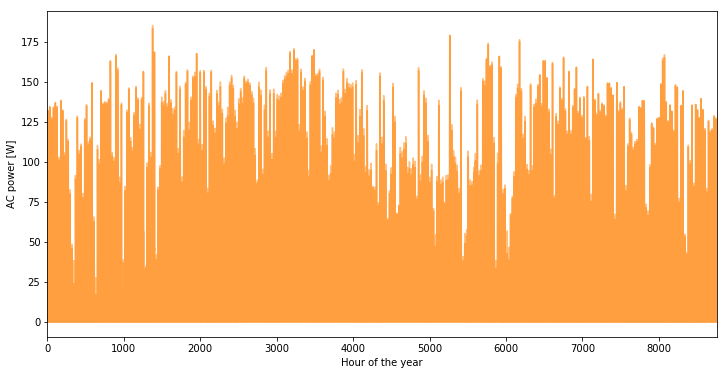

In [26]:
plot_x = np.arange(0, tmy.shape[0])

fig, ax = plt.subplots(figsize=[12,6])
ax.plot(plot_x, power, zorder = 1, color=colours.orange, alpha=0.5)
plt.ylabel('AC power [W]')
plt.xlabel('Hour of the year')
plt.xlim(plot_x[0], plot_x[-1])
plt.show()

In [27]:
ts = syndata.iloc[0:n_hours, :].values
fpath_out = os.path.join("..", "ddn", "ddn_syn.epw")
wf.give_weather(ts, locdata=locdata, stcode='ddn', header=header,
                 masterfile=path_epw_ddn, ftype='epw',
                 s_shift=0, fpath_out=fpath_out)

You asked for 1 files to be written out. I was able to write out 1 files successfully.
Out file path is ..\ddn\ddn_syn.epw


In [28]:
ddn_syn, locdata_syn, header_syn, _ = wf.get_weather('ddn_syn', fpath_out, ftype='epw')

Running weather file reader for station ddn_syn. Expecting format epw.



In [30]:
power_syn = solar.tmy_to_power(path_tmy_data=fpath_out,
                           surface_tilt=30, surface_azimuth=180,
                           albedo=0.2, silent=True)

Running weather file reader for station tmy_data. Expecting format epw.



C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1463: RuntimeWarning: invalid value encountered in maximum
  spectral_loss = np.maximum(0, np.polyval(am_coeff, airmass_absolute))
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1317: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1323: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +
C:\Miniconda3\lib\site-packages\pvlib\pvsystem.py:1919: RuntimeWarning: overflow encountered in exp
  (Gsh[idx_p]*a[idx_p]))


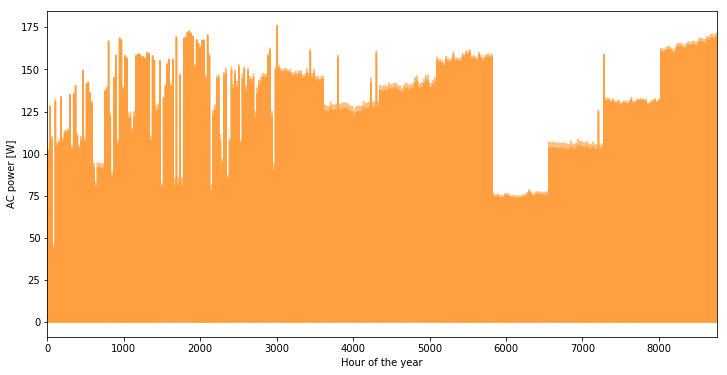

In [31]:
plot_x = np.arange(0, tmy.shape[0])

fig, ax = plt.subplots(figsize=[12,6])
ax.plot(plot_x, power_syn, zorder = 1, color=colours.orange, alpha=0.5)
plt.ylabel('AC power [W]')
plt.xlabel('Hour of the year')
plt.xlim(plot_x[0], plot_x[-1])
plt.show()

## Uncertainty analysis with EPlus

### Steps/Notes

1. Consider weather inputs from Indra.
2. Run samples using EPlus - analyse results.
    1. Either modify a base EPlus file using Eppy/scripting or in jePlus.
    2. Or analyse the same EPlus file using many weather files.